# Enzyme Cost Minimization -- hands-on
## Example on the Central Carbon Metabolism of *Escherichia coli*

Code re-used from the `examples` folder in the [equilibrator-pathway](https://gitlab.com/equilibrator/equilibrator-pathway) Git repository, maintained by Elad Noor and colleagues. *Very* minor modifications to the initial Jupyter notebook, while preparing for the PICP_scholars session, done by Pranas Grigaitis.

Reference:
Noor E, Flamholz A, Bar-Even A, Davidi D, Milo R, Liebermeister W (2016) [The Protein Cost of Metabolic Fluxes: Prediction from Enzymatic Rate Laws and Cost Minimization.](https://doi.org/10.1371/journal.pcbi.1005167) *PLoS Comput Biol* 12(11)

## 0. Prepping

First, make sure all of the required `pip` packages are installed and running in your Google Collab environment. Then attempt importing required functions AND run the last cell of this section to download the eQuilibrator thermodynamics database.

In [ ]:
pip install equilibrator_api equilibrator_pathway tqdm pandas numpy matplotlib sbtab!git clone https://github.com/pranasag/PICP_EnzymeCostMinimization.git

**Note:** Go to `Kernel -> Restart` and continue with the next tab.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import pandas as pd
from sbtab import SBtab

from equilibrator_api import ComponentContribution, Q_
from equilibrator_pathway.cost_function import EnzymeCostFunction
from equilibrator_pathway.ecm_model import EnzymeCostModel

In [ ]:
comp_contrib = ComponentContribution()

## 1. Setting up the CCM model and validation data

First, we load the model (provided in `SBtab` format) as an ECM model object, and supply validation data. Then, we optimize the model: minimize sum cost of the enzymes, weighted by the arbitrary weight (currently all 1) and kinetic properties (kcat and Km values); see model file.

Validation data source: 
van Rijsewijk BRBH, Nanchen A, Nallet S, Kleijn RJ, Sauer U. Large-scale 13C-flux analysis reveals distinct transcriptional control of respiratory and fermentative metabolism in Escherichia coli. *Mol Syst Biol.* 2011;7(477):477

In [ ]:
model = EnzymeCostModel.from_sbtab("ecoli_noor_2016_ecm.tsv", comp_contrib=comp_contrib)
model.add_validation_data("ecoli_noor_2016_reference.tsv")

In [ ]:
model.ecf.params["denominator"] = "CM"

In [ ]:
%%time
print('Solving ECM problem')
ecm_sol = model.optimize_ecm()
res_sbtab = ecm_sol.to_sbtab()

## 2. (Graphical) analysis of the ECM output

We have performed optimization and can now look at the computed costs.
**Note**: uncomment the last lines (`plt.show()`) to see the produced figures.

Recap from the short talk that we have different components, influencing the amount of the enzyme required to sustain a given flux. We can show how much every component adds up to the demand by plotting the protein demand with incrementing number of components present.

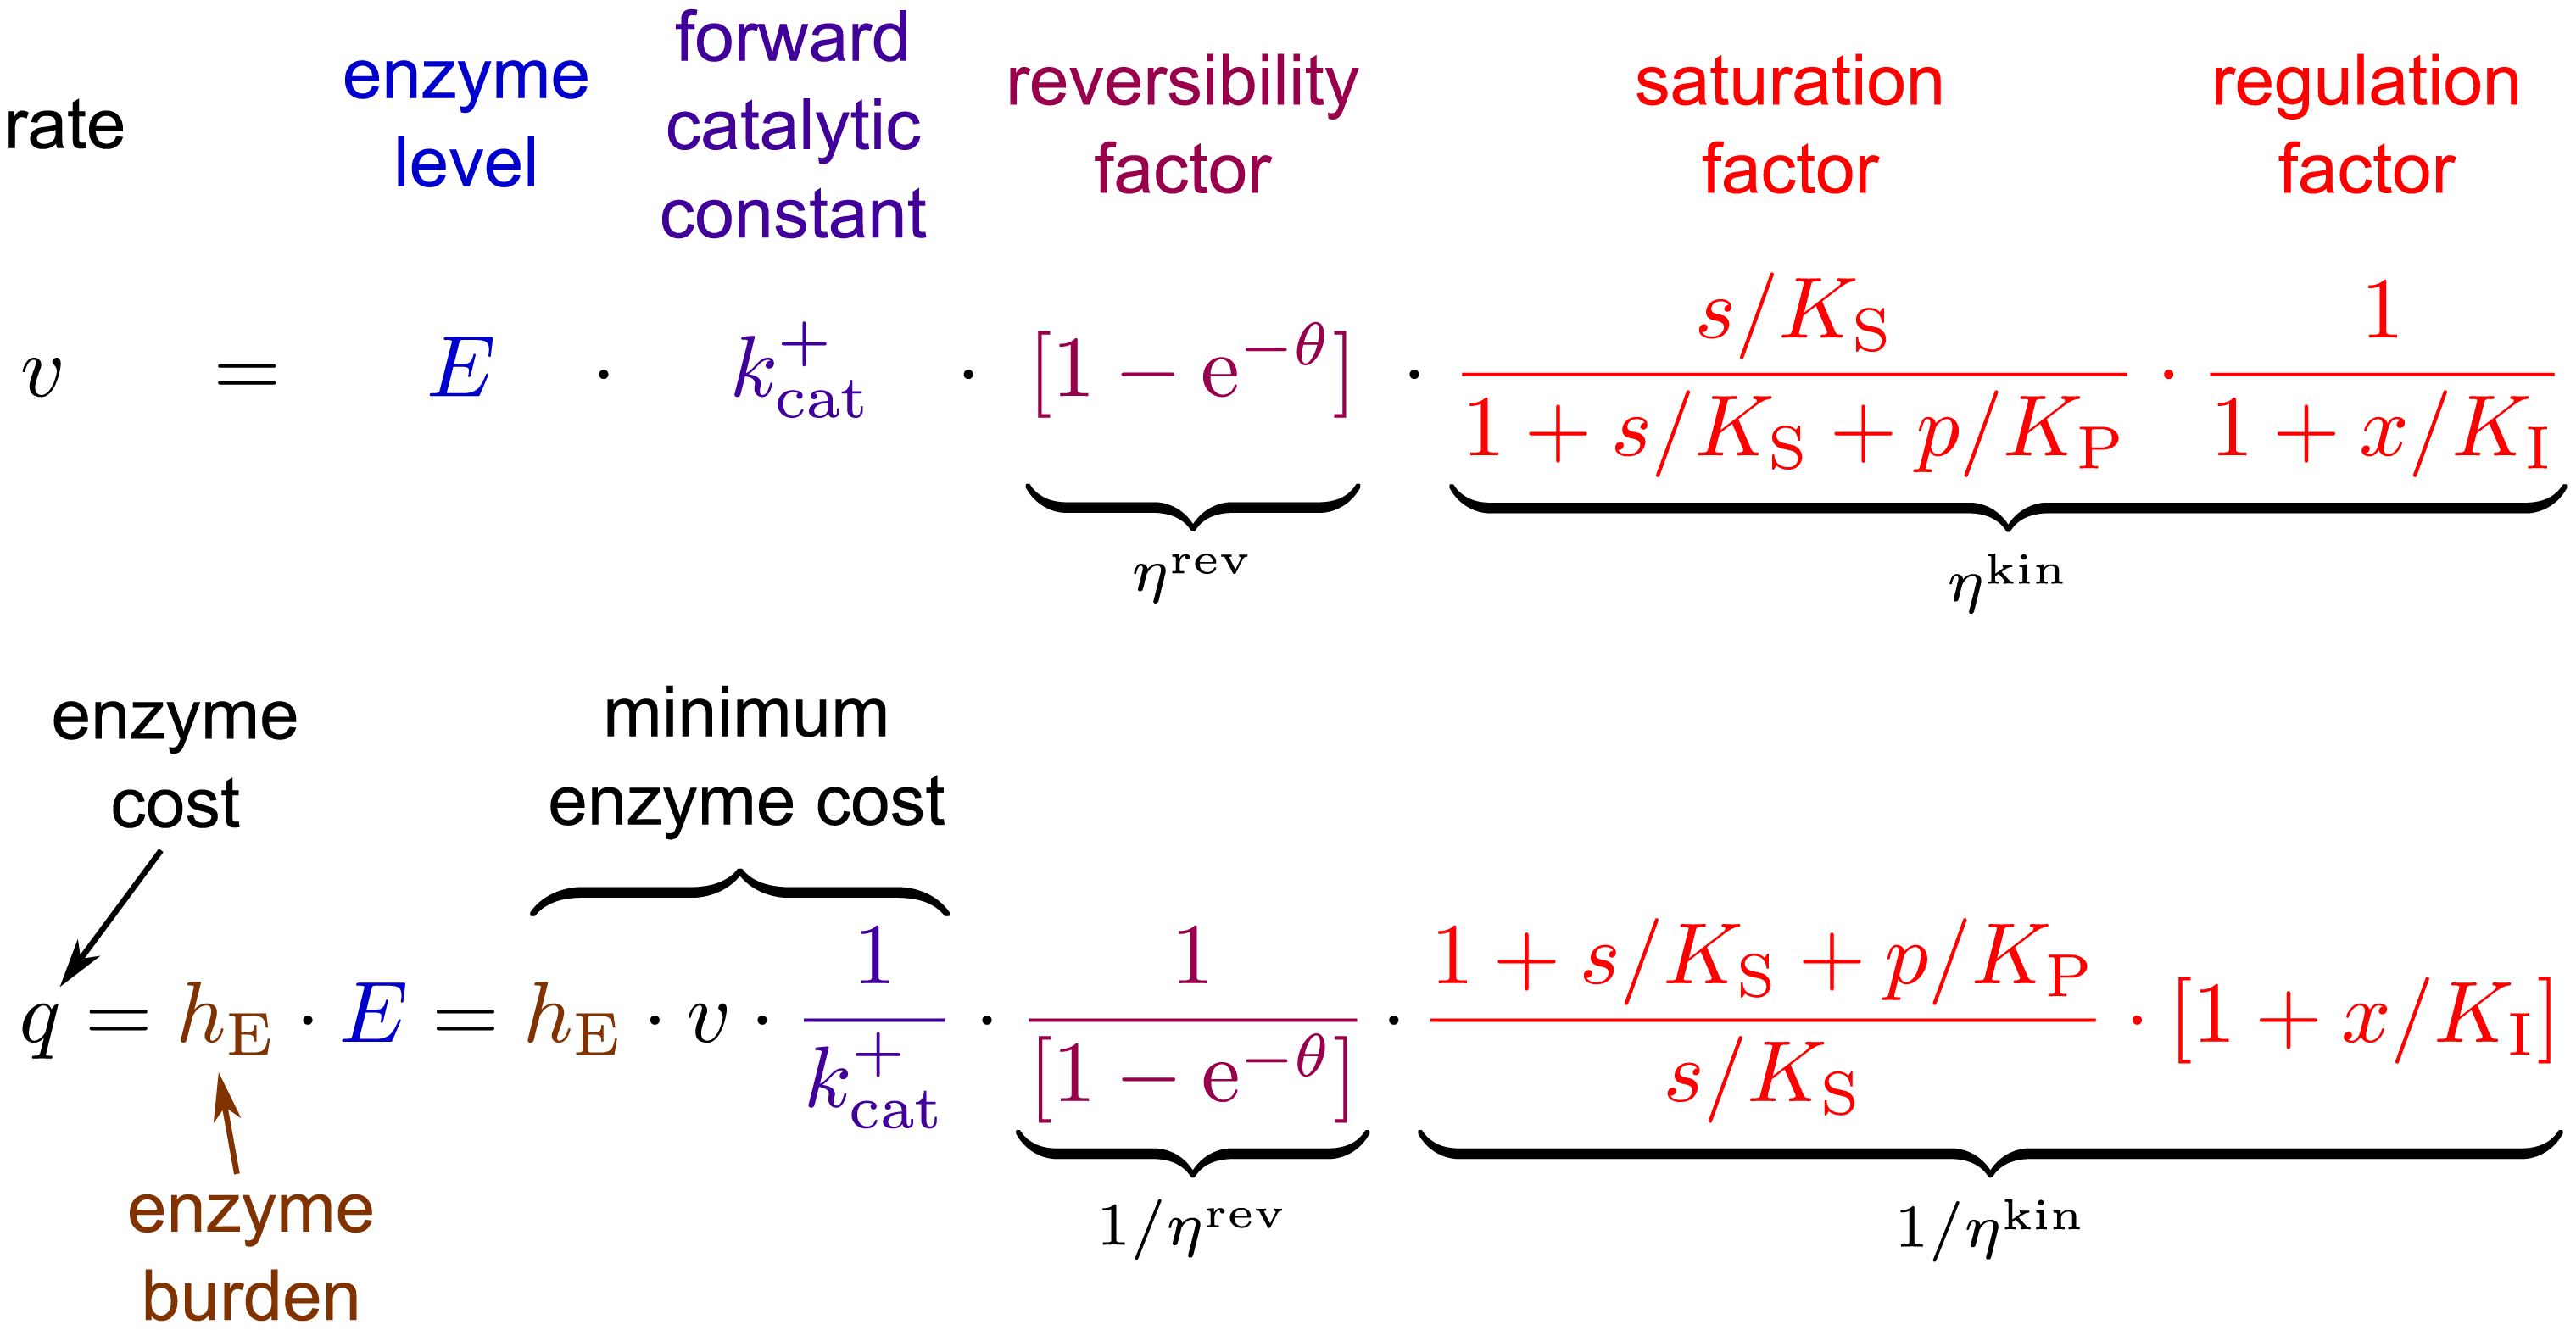
(Noor *et al.* 2016 *PLoS Comp Biol*)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (10,7))
ax = ax.ravel()

fig.suptitle("Computed enzyme demand, different cost layers")
subplotTitles = {1: "Enzyme capacity alone", 
                 2: "Enzyme capacity + reversibility component", 
                 3: "Enzyme capacity, reversibility, and saturation"}

for i in range(1,4):
    ecm_sol.plot_enzyme_demand_breakdown(ax[i-1], top_level = i, plot_measured=True)
    ax[i-1].set_ylim(1e-8, 1e-3);
    ax[i-1].get_legend().remove()
    ax[i-1].set_title(subplotTitles[i])
    if i < 3: ax[i-1].get_xaxis().set_visible(False)
ax[2].legend(loc="center left", bbox_to_anchor=(1, 0.5));
#plt.show()

Next, we consider only the full prediction (meaning all 3 layers of costs presented above). We take this prediction and compare predicted metabolite concentrations and enzyme concentrations against the validated data. Optionally we can visualize the partitioning of proteins in a pie-plot.

In [ ]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(1, 3, 1, xscale='log', yscale='log')
ax.set_title('Metabolite Concentrations')
ecm_sol.validate_metabolite_conc(ax)

ax = fig.add_subplot(1, 3, 2, xscale='log', yscale='log')
ax.set_title('Enzyme Concentrations')
ecm_sol.validate_enzyme_conc(ax)

ax = fig.add_subplot(1, 3, 3)
ecm_sol.plot_volumes_pie(ax=ax)
#plt.show()

The entirety of information, generated by the ECM method, can be accessed using `pandas` dataframes, as well as exported in SBtab format.

In [ ]:
#ecm_sol.compound_df.head()
#ecm_sol.reaction_df.head()
#ecm_sol.enzyme_df.head()
#print(ecm_sol.to_sbtab().to_str())

## 3. Play time!

Now, after we saw the "nice" example, with the proper data being fed to the model, we can look into different ways to either break the model or to make it even better. Here are several scenarios/questions that you could consider. No need to run/test them all, but - as they say - practice makes perfect. 

**Note**: if you modify anything in the model `ecoli_noor_2016_ecm.tsv`, make sure you make a copy of the original dataset.

* Consider changing "EnzymeCostWeight" in the model, so their values differ for, e.g. upper glycolysis, compared to lower glycolysis; respiration mode (TCA cycle proteins); pentose phosphate pathway. Could be just a simple numeric change (e.g. 1 -> 2) or something extreme, you tell!
* Model has different constraints on concentrations in the cell ("ConcentrationConstraint"). Many of them are arbitrary, say, from 1e-3 to 1e1 mM, some of them are fixed. You might guess that some of them must be fixed, so let's consider with the concentrations which are at the default bounds. Want to play with them? Be my guest! How would you systematically try to find which concentrations, in fact, can form larget feasible intervals of concentrations, and which are tighly regulated? (hint: kinetics!)
* Can you identify current bottlenecks in the CCM of *E. coli*? Try adjusting some kinetic parameters or initial concentrations in the model.
* To the moon and beyond! Imagine we put *E. coli* in highly CO2-enriched environment, its concentration increases 100-fold. Do we observe anything suspicious in the metabolism? Try mingling with some more fixed concentrations.
* Set all the concentrations to 1. What effect do you remove from the enzyme costs? (see above)